In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, freqz

from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [21]:
sns.set(rc = {'figure.figsize':(30, 16)})
data = pd.read_csv('data.tsv', sep='\t')

In [22]:
data = data[['Gaze point X',
             'Gaze point Y',
             'Gaze point 3D X',
             'Gaze point 3D Y',
             'Gaze point 3D Z',
             'Pupil position left X',
             'Pupil position left Y',
             'Pupil position left Z',
             'Pupil position right X',
             'Pupil position right Y',
             'Pupil position right Z',
             'Pupil diameter left',
             'Eye movement type',
             'Computer timestamp']]

data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data['Computer timestamp'] = data['Computer timestamp'] / (1000 * 1000)

ma = 10

data['Gaze point X'] = data['Gaze point X'].rolling(ma).mean()
data['Gaze point Y'] = data['Gaze point Y'].rolling(ma).mean()

data['Gaze point 3D X'] = data['Gaze point 3D X'].rolling(ma).mean()
data['Gaze point 3D Y'] = data['Gaze point 3D Y'].rolling(ma).mean()
data['Gaze point 3D Z'] = data['Gaze point 3D Z'].rolling(ma).mean()

data['Pupil position left X'] = data['Pupil position left X'].rolling(ma).mean()
data['Pupil position left Y'] = data['Pupil position left Y'].rolling(ma).mean()
data['Pupil position left Z'] = data['Pupil position left Z'].rolling(ma).mean()

data['Pupil position right X'] = data['Pupil position right X'].rolling(ma).mean()
data['Pupil position right Y'] = data['Pupil position right Y'].rolling(ma).mean()
data['Pupil position right Z'] = data['Pupil position right Z'].rolling(ma).mean()

data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

dy = data.index.to_series().diff()
dxX = data['Gaze point X'].diff()
dxY = data['Gaze point Y'].diff()

data.drop(0, inplace=True)
data['SPEED_DIFF_X'] = dxX / dy
data['SPEED_DIFF_Y'] = dxY / dy

data.reset_index(inplace=True, drop=True)

data['SPEED_DIFF_X'] = data['SPEED_DIFF_X']
data['SPEED_DIFF_Y'] = data['SPEED_DIFF_Y']


data = data[data['Eye movement type'] != 'Unclassified']
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

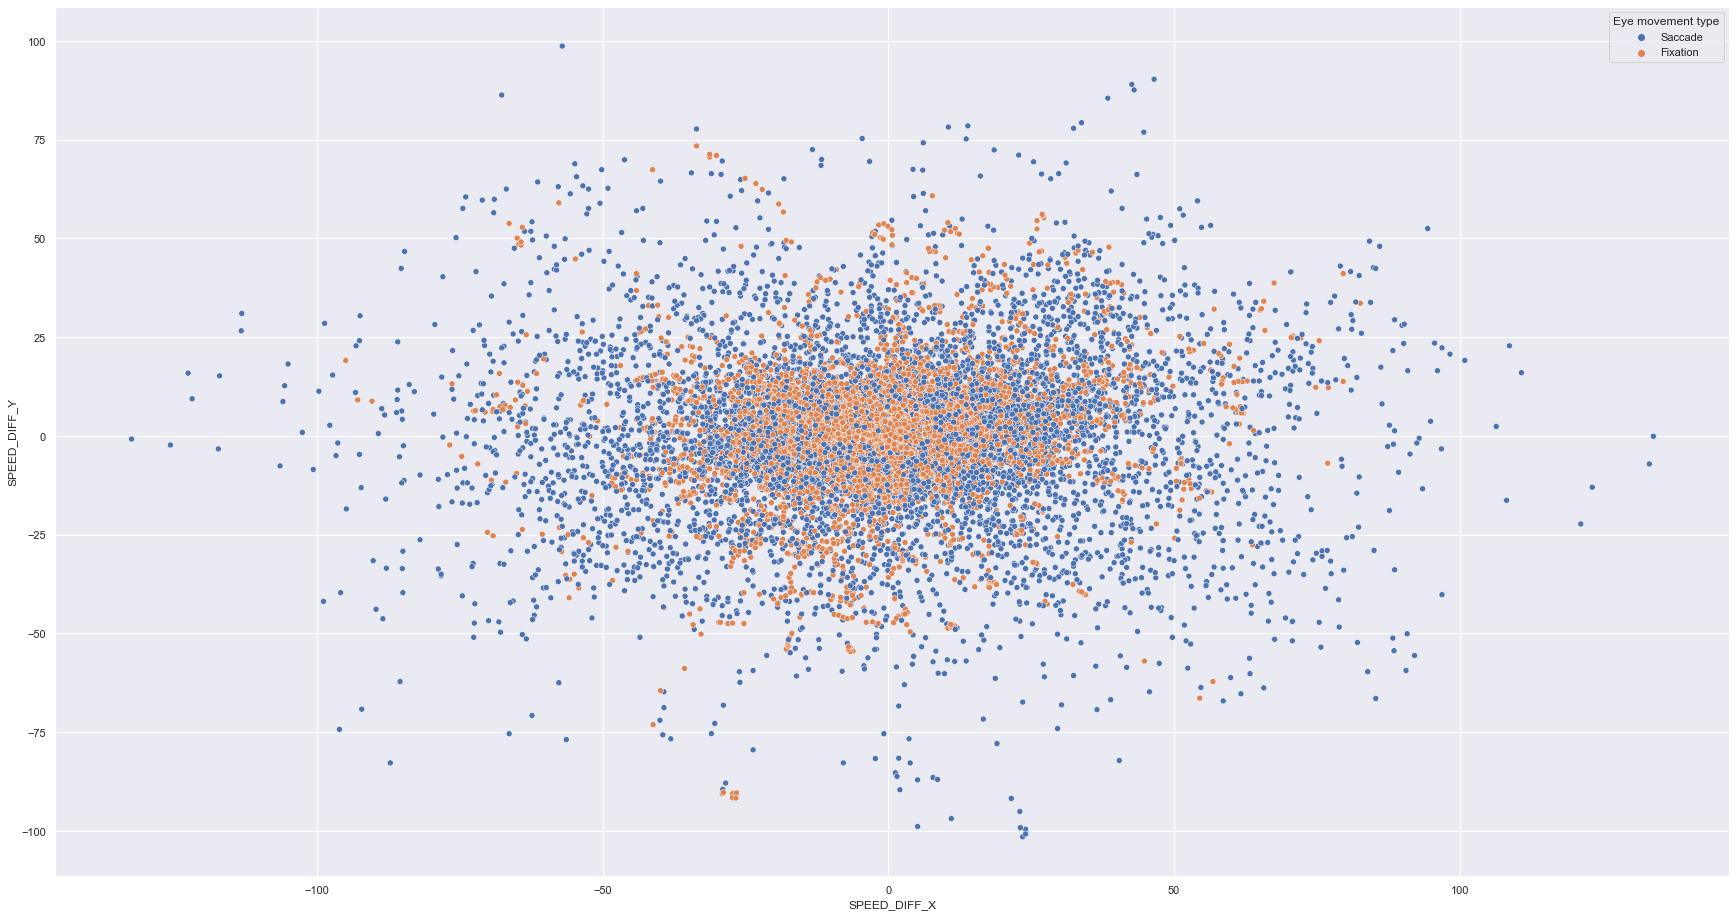

In [23]:
sns.scatterplot(x=data['SPEED_DIFF_X'], y=data['SPEED_DIFF_Y'], hue=data['Eye movement type'])

In [24]:
data['PUPIL_Z_AVG'] = (data['Pupil position left Z'] + data['Pupil position right Z']) / 2
data['PUPIL_X_AVG'] = (data['Pupil position left X'] + data['Pupil position right X']) / 2
data['PUPIL_Y_AVG'] = (data['Pupil position left Y'] + data['Pupil position right Y']) / 2

data['VECTOR1_X'] = + data['PUPIL_X_AVG'] - data['Pupil position left X']
data['VECTOR1_Y'] = + data['PUPIL_Y_AVG'] - data['Pupil position left Y']
data['VECTOR1_Z'] = + data['PUPIL_Z_AVG'] - data['Pupil position left Z']

data['VECTOR2_X'] = + data['PUPIL_X_AVG'] - data['Pupil position right X']
data['VECTOR2_Y'] = + data['PUPIL_Y_AVG'] - data['Pupil position right Y']
data['VECTOR2_Z'] = + data['PUPIL_Z_AVG'] - data['Pupil position right Z']

# arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

data['ANGLE'] = np.arccos((data['VECTOR1_X'] * data['VECTOR2_X'] + data['VECTOR1_Y'] * data['VECTOR2_Y'] + data['VECTOR1_Z'] * data['VECTOR2_Z']) \
/ (np.sqrt(data['VECTOR1_X'] ** 2 + data['VECTOR1_Y'] ** 2 + data['VECTOR1_Z'] ** 2) * np.sqrt(data['VECTOR2_X'] ** 2 + data['VECTOR2_Y'] ** 2 + data['VECTOR2_Z'] ** 2)))


dy = np.diff(data['Computer timestamp'])

data.drop(0, inplace=True)
data.reset_index(inplace=True)
data['ANGLE_VEL'] = data['ANGLE'] / dy
data.dropna(inplace=True, subset=['ANGLE_VEL'])
data.reset_index(inplace=True)

data['ANGLE_VEL'].mean(), data['ANGLE_VEL'].std(), data['ANGLE_VEL'].max()

(147.72666796523072, 30.566721569960357, 157.71839142090658)

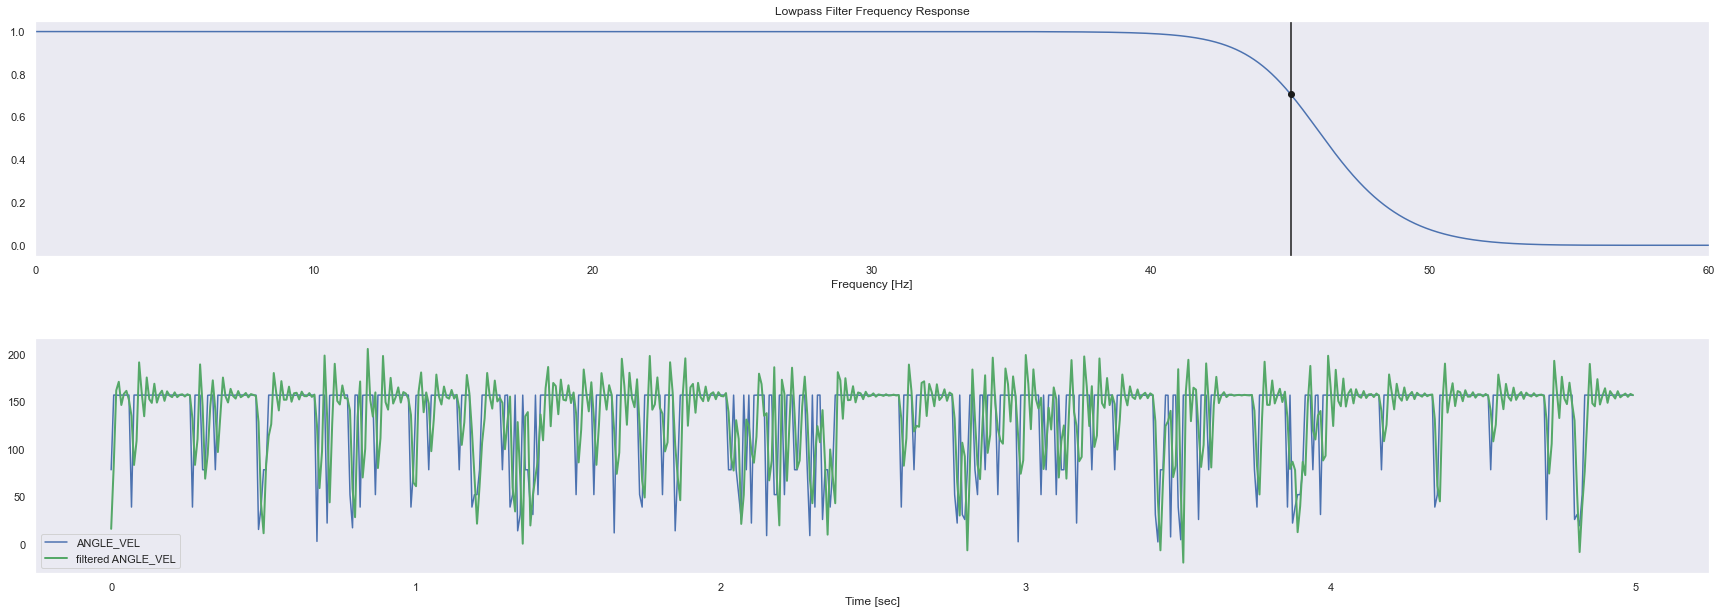

In [25]:
# Setting standard filter requirements.
order = 6
fs = 120.0       
cutoff = 45

nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)


# Filtering
data['ANGLE_VEL_FILTERED'] = lfilter(b, a, data['ANGLE_VEL'])
# data['LOW_PASS_Y'] = lfilter(b, a, data['SPEED_DIFF_Y'])


T = 5.0         # value taken in seconds
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)

w, h = freqz(b, a, worN=8000)
plt.subplot(3, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')


plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, data.loc[:n-1]['ANGLE_VEL'], 'b-', label='ANGLE_VEL')
plt.plot(t, data.loc[:n-1]['ANGLE_VEL_FILTERED'], 'g-', linewidth=2, label='filtered ANGLE_VEL')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

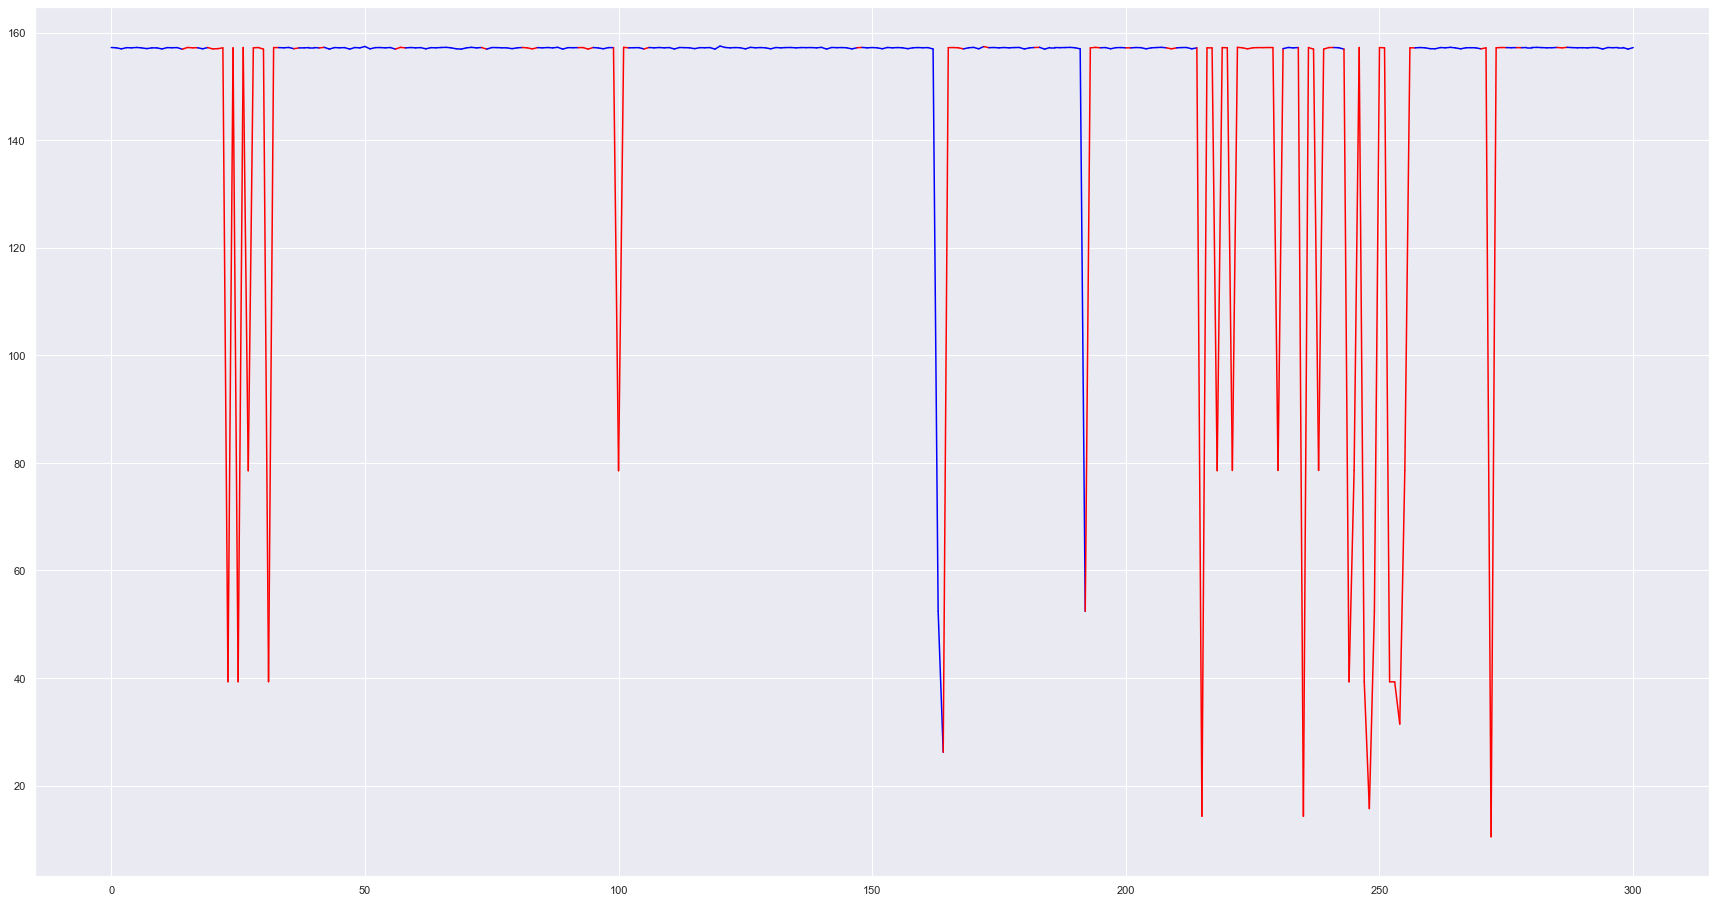

In [41]:
plot_data = data.loc[2000:2300]
plot_data.reset_index(inplace=True, drop=True)
plot_data['colors'] = np.where(plot_data['Eye movement type'] == 'Fixation', 'blue', 'red')

for idx, row in plot_data.iterrows():
    if idx + 2 > len(plot_data):
        break
    sns.lineplot([idx, idx+1], [row['ANGLE_VEL'], plot_data.loc[idx+1, 'ANGLE_VEL']], color=row['colors'])

In [46]:
data['PRED_TYPE'] = np.where(data['ANGLE_VEL'] > 145, 'Fixation', 'Saccade')
print(classification_report(data['Eye movement type'], data['PRED_TYPE']))

              precision    recall  f1-score   support

    Fixation       0.81      0.98      0.89     23111
     Saccade       0.84      0.31      0.45      7575

    accuracy                           0.81     30686
   macro avg       0.82      0.65      0.67     30686
weighted avg       0.82      0.81      0.78     30686



<AxesSubplot:xlabel='count', ylabel='Eye movement type'>

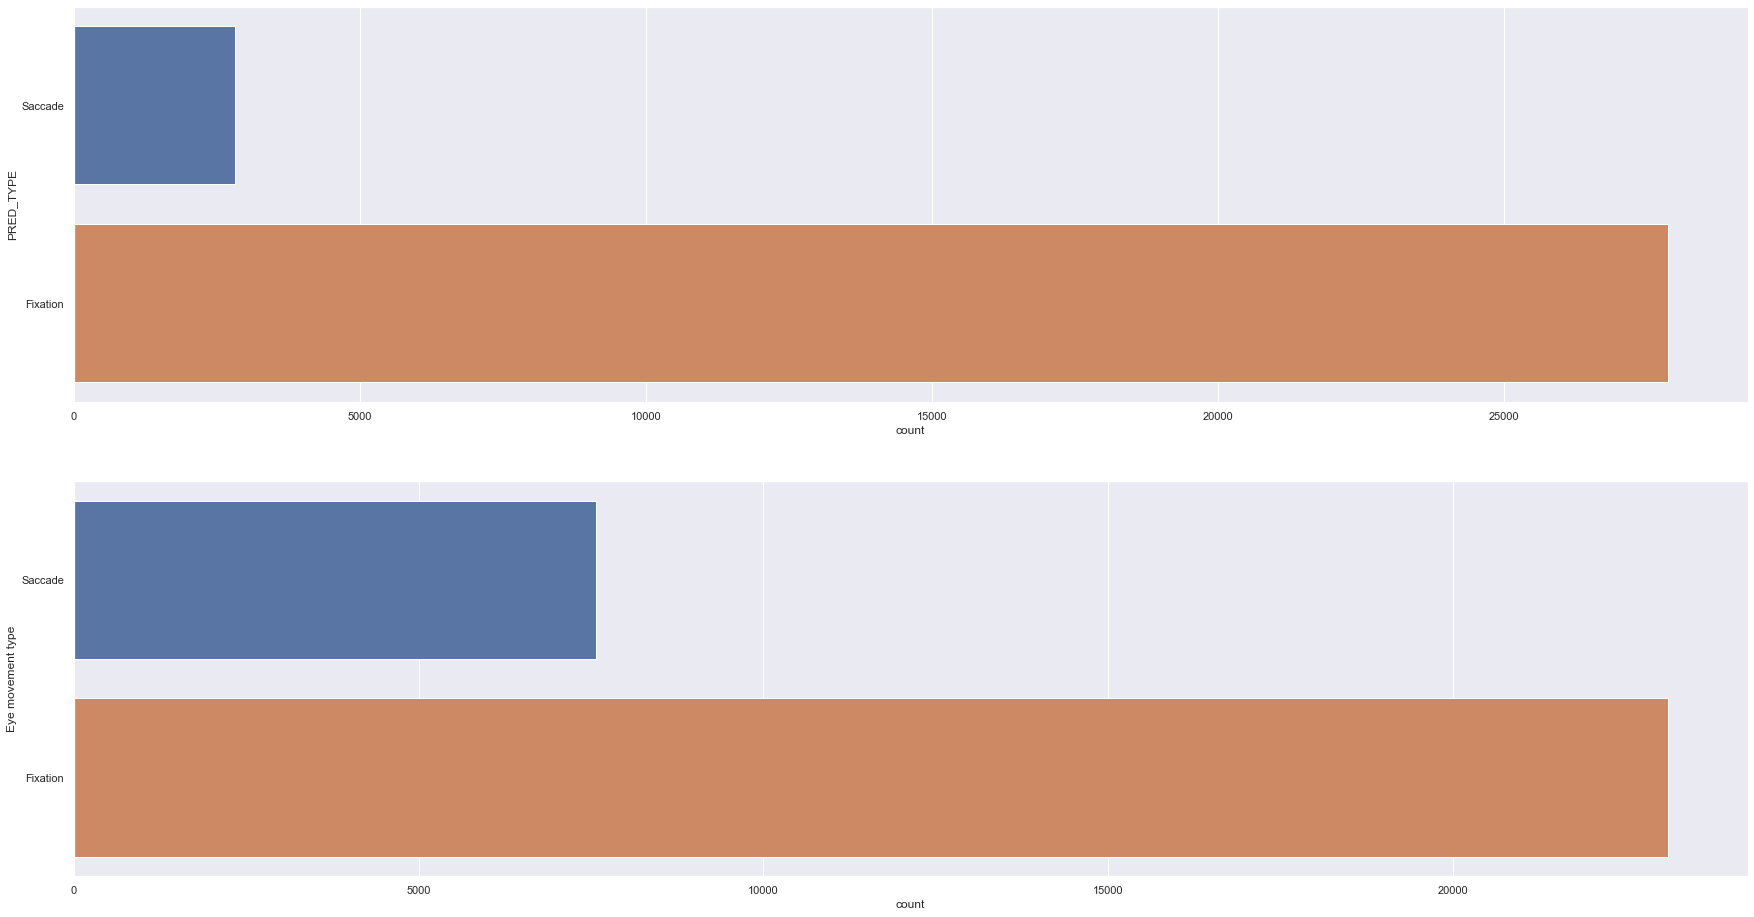

In [47]:
plt.subplot(2, 1, 1)
sns.countplot(data=data, y='PRED_TYPE')
plt.subplot(2, 1, 2)
sns.countplot(data=data, y='Eye movement type')

In [29]:
# fixation_count = len(data[data['Eye movement type'] == 'Fixation'])
# saccade_count = len(data[data['Eye movement type'] == 'Saccade'])
# total = len(data['Eye movement type'])

In [30]:
# import tensorflow as tf

# from keras.models import Sequential
# from keras.layers import *
# import keras

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [31]:
# scaler = StandardScaler()
# for col in data.columns:

#     if col in ['Eye movement type', 'Recording timestamp']:
#         continue
    
#     data[col] = scaler.fit_transform([data[col]])[0]


# data['Eye movement type'] = data['Eye movement type'].replace('Fixation', 1)
# data['Eye movement type'] = data['Eye movement type'].replace('Saccade', 0)
# Y = data['Eye movement type'] = data['Eye movement type'].replace('Fixation', 0)
# X = data.drop(['Eye movement type', 'Recording timestamp'], axis=1).to_numpy()

In [32]:
# X_sequences = []
# Y_sequences = []

# seq_length = 15
# len_features = len(X[0])

# for i in range(seq_length, len(X)):

#     if i + seq_length > len(X):
#         break

#     X_sequences.append(X[i-seq_length:i])
#     Y_sequences.append(Y[i])a

# np.shape(X_sequences), np.shape(Y_sequences)

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, Y_sequences, test_size=0.25)

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_test, y_test = np.array(X_test), np.array(y_test)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len_features))
# # y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 3))

# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len_features))
# # y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 3))

# np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

In [34]:
# lr = 3e-5

# weight_for_0 = (1 / saccade_count) * (total / 2.0)
# weight_for_1 = (1 / fixation_count) * (total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}


# model = Sequential()
# model.add(LSTM(units=256, activation='relu', return_sequences=False, input_shape=(seq_length, len_features)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics=['Accuracy', keras.metrics.AUC(name='prc', curve='PR')])
# model.summary()

In [35]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=100, mode='max')

In [36]:
# epochs = 200
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=2048, callbacks=[], class_weight=class_weight)

In [37]:
# plt.style.use("ggplot")

# plt.plot(range(len(history.history['Accuracy'])), history.history['Accuracy'])
# plt.plot(range(len(history.history['Accuracy'])), history.history['val_Accuracy'])

# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [38]:
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))